In [ ]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html


In [1]:
import torch
from torch_geometric.data import InMemoryDataset, download_url, Dataset, Data
import numpy as np
import pandas as pd
import os
from google.colab import drive
from tqdm import tqdm
import torch_geometric
import networkx as nx
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv

drive.mount('/content/gdrive')
#give access for drive  
#Change The Path for testing
path="gdrive/My Drive/IFT6253-Milestone1/data"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
! pip install feature-engine

Processing...
100%|██████████| 1/1 [00:00<00:00, 2792.48it/s]
Done!
/usr/local/lib/python3.7/dist-packages/torch_geometric/data/storage.py:264: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_attr', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  " to suppress this warning")


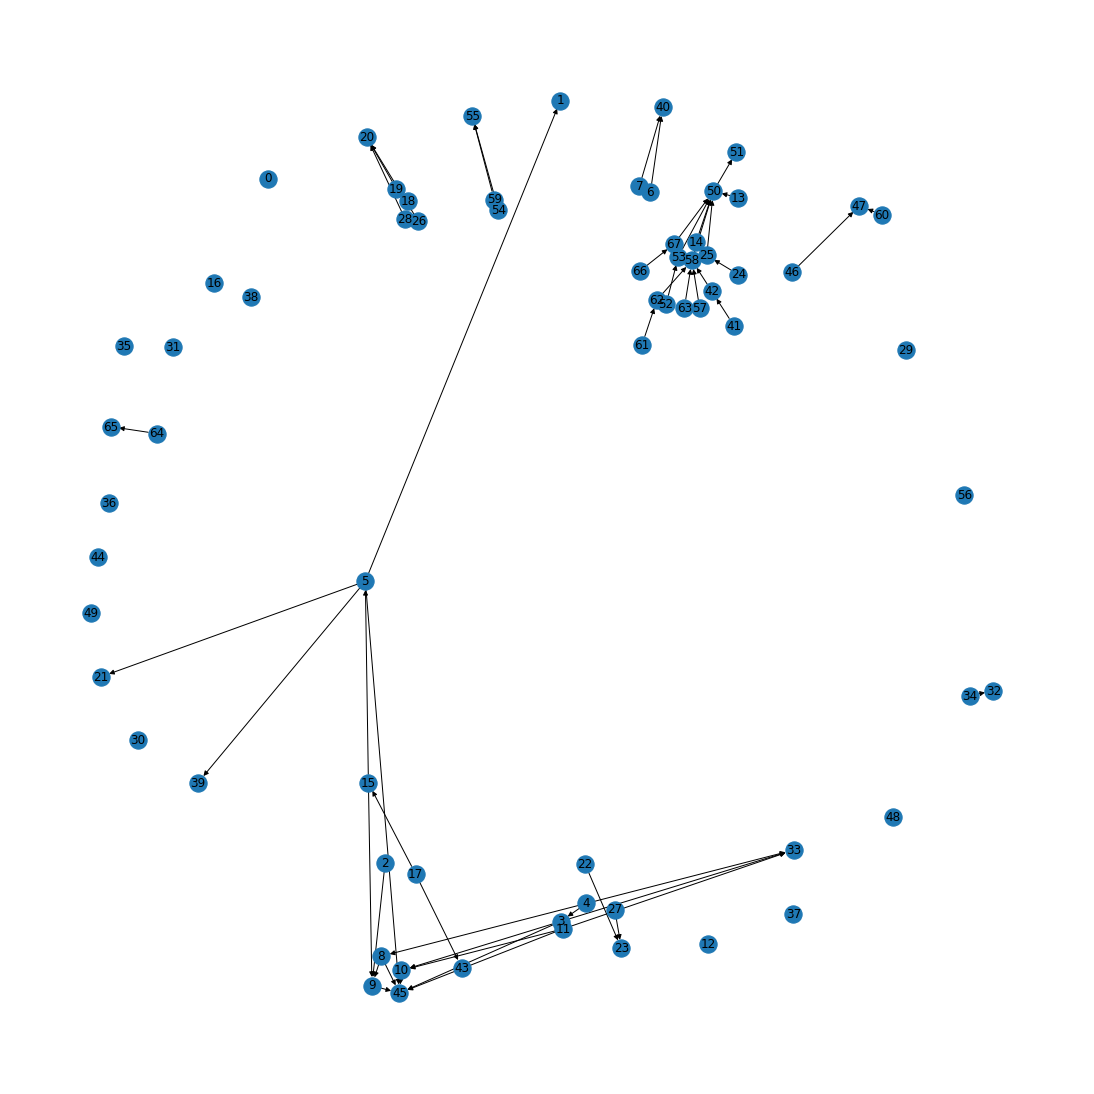

In [2]:
from feature_engine.encoding import OrdinalEncoder
from matplotlib import pyplot as plt

class CodeConceptsGraphDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(CodeConceptsGraphDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [
            'nodes.csv', 'edges.csv', 'num-node-list.csv', 'num-edge-list.csv',
            'node-types.csv', 'edge-relations.csv', 'node-vocab-mapping.csv', 'data.jsonl'
        ]

    @property
    def processed_file_names(self):
        return 'geometric_data_processed.pt'

    def download(self):
        pass

    def process(self):
     

        nodes_data = pd.read_csv(path+'/DEMO/data_nodes.csv', header=None)
        nodes_data = nodes_data.iloc[1: , :]
        edges_data = pd.read_csv(path+'/DEMO/AllEdges_edges.csv')
        nodes_data=nodes_data.dropna()
        edges_data=edges_data.dropna()
        edges_data=edges_data[['type','source', 'target' ]]
    
        num_node_list=[nodes_data.shape[0]]
        num_edge_list=[edges_data.shape[0]]
        nodes_feat_names = nodes_data.values.T[1]
        nodes_feat_types = nodes_data.values.T[2]
        
        edges = edges_data.values.T[1:].astype(np.int64)
        edges_feat = edges_data.values.T[0].astype(np.int64)

        graph_list = []
        num_node_accum = 0
        num_edge_accum = 0

        for idx, (num_node, num_edge) in enumerate(tqdm(zip(num_node_list, num_edge_list), total=len(num_node_list))):
            graph = dict()

            graph['edge_index'] = edges[:, num_edge_accum:num_edge_accum + num_edge]
            graph['edge_feat'] = edges_feat[num_edge_accum:num_edge_accum + num_edge]

            num_edge_accum += num_edge

            graph['num_nodes'] = num_node
            graph['node_attributes'] = nodes_feat_types[num_node_accum:num_node_accum + num_node]
 
            num_node_accum += num_node


            graph_list.append(graph)

        graph_data = []
        for graph in tqdm(graph_list):
            g = Data()
            g.__num_nodes__ = graph['num_nodes']
            g.edge_index = torch.from_numpy(graph['edge_index'])

            del graph['num_nodes']
            del graph['edge_index']

            g.edge_attr = torch.from_numpy(graph['edge_feat'])
            del graph['edge_feat']



            graph_data.append(g)

        if self.pre_transform is not None:
            graph_data = [self.pre_transform(data) for data in graph_data]

        data, slices = self.collate(graph_data)
        torch.save((data, slices), self.processed_paths[0])


if __name__ == '__main__':
    dataset = CodeConceptsGraphDataset(root=path)

    edge,x = dataset[0]
    numpyx = x[1].numpy()
    numpyedge = edge[1].numpy()
    #should be undirected 
    g = torch_geometric.utils.to_networkx(dataset[0],  to_undirected=False )
    idx=0
    for i in range(len(g.edges)):
      g[edge[1][0][i].item()][edge[1][1][i].item()]['type']=numpyx[i]
      idx+=1
    pos = nx.spring_layout(g)
    edge_labels = nx.get_edge_attributes(g,'type')
    fig = plt.figure(1, figsize=(15,15))
    
    nx.draw(g, pos,with_labels=True )
